In [15]:
import matplotlib
%matplotlib inline

In [5]:
import phoebe
import numpy as np
from spice.spectrum import simulate_observed_flux
from transformer_payne import Blackbody
from phoebe.parameters.dataset import _mesh_columns
from spice.models.binary import PhoebeBinary
from spice.models.phoebe_utils import PhoebeConfig
from spice.spectrum import AB_passband_luminosity
from spice.spectrum.filter import *
import pickle
from tqdm import tqdm
import os

from jax import config
print(jax.devices())

PHOEBE_PASSBAND_PATH = '/home/100/mj8805/scr/mj8805/spice/passbands'

def load_phoebe_passband(fname: str):
    with open(fname, 'rb') as f:
        struct = pickle.load(f)
        return struct
    
def get_transmission_curve(phoebe_passband):
    return phoebe_passband['ptf_func'][0]*1e11, phoebe_passband['ptf_func'][1]


def create_phoebe_filter(phoebe_passband):
    # Extract wavelengths and transmission values from PHOEBE passband
    wavelengths, transmission = get_transmission_curve(phoebe_passband)
    wavelengths = wavelengths * 1e-1
    
    # Create transmission curve as a 2D array
    transmission_curve = np.array([wavelengths, transmission])
    
    # Create a Filter object
    filter_name = f"{phoebe_passband['pbset']}:{phoebe_passband['pbname']}"
    phoebe_filter = Filter(transmission_curve, name=filter_name)
    
    return phoebe_filter

[CudaDevice(id=0)]


In [6]:
os.path.join(PHOEBE_PASSBAND_PATH, 'johnson_u.pb3')

'/home/100/mj8805/scr/mj8805/spice/passbands/johnson_u.pb3'

In [11]:
# Check if the Gaia passband file exists
gaia_passband_path = os.path.join(PHOEBE_PASSBAND_PATH, 'gaia_G.pb3')
if os.path.exists(gaia_passband_path):
    print(f"Gaia passband file exists at: {gaia_passband_path}")
else:
    print(f"WARNING: Gaia passband file not found at: {gaia_passband_path}")



Gaia passband file exists at: /home/100/mj8805/scr/mj8805/spice/passbands/gaia_G.pb3


In [61]:
period = 5.0
incl = 90.
q = 0.5
primary_mass = 1.0
ecc = 0.0

print("Creating default binary system")
b = phoebe.default_binary()
times = np.linspace(0, period, 100)
COLUMNS = _mesh_columns

print("Adding datasets to binary system")
b.add_dataset('mesh', times=times, columns=COLUMNS, dataset='mesh01')
b.add_dataset('orb', compute_times=times, dataset='orb01')
b.add_dataset('lc', compute_times=times, passband='Johnson:U', dataset='lc_johnson_u')
b.add_dataset('lc', compute_times=times, passband='Johnson:V', dataset='lc_johnson_v')
b.add_dataset('lc', compute_times=times, passband='Stromgren:v', dataset='lc_stromgren_v')
b.add_dataset('lc', compute_times=times, passband='Gaia:G', dataset='lc_gaia_g')
b.add_dataset('lc', compute_times=times, passband='Bolometric:900-40000', dataset='lc_bolometric')

print("Setting binary system parameters")
b.set_value_all('incl@binary', incl)
b.set_value('period@binary', period)
b.set_value('q@binary@component', q)
b.set_value('ecc@binary@component', ecc)
b.flip_constraint('mass@primary', solve_for='sma')
b.set_value('mass@primary@component', primary_mass)
b.set_value_all('ld_mode', 'manual')
b.set_value_all('ld_func', 'linear')
b.set_value_all('ld_coeffs', [0.])
b.set_value_all('ld_mode_bol', 'manual')
b.set_value_all('ld_func_bol', 'linear')
b.set_value_all('ld_coeffs_bol', [0.])
b.set_value_all('atm', 'blackbody')

print("Running PHOEBE compute")
b.run_compute(irrad_method='none', coordinates='uvw', ltte=False)

print("Creating Blackbody model")
bb = Blackbody()
p1 = PhoebeConfig(b, 'mesh01', 'orb01')
pb = PhoebeBinary.construct(p1, bb.parameter_names, {pn: sp for pn, sp in zip(bb.parameter_names, bb.solar_parameters)})
from spice.models.binary import evaluate_orbit 

print("Evaluating orbits")
pbs = [evaluate_orbit(pb, t) for t in times]

print("Simulating observed fluxes")
ws = np.linspace(900, 40000, 1000)
s1s_no_d = [simulate_observed_flux(bb.intensity, pb1, np.log10(ws), disable_doppler_shift=True) for pb1, _ in pbs]
s2s_no_d = [simulate_observed_flux(bb.intensity, pb2, np.log10(ws), disable_doppler_shift=True) for _, pb2 in pbs]

print("Calculating PHOEBE differences")
diffs_phoebe = []
for dataset in ['lc_johnson_u', 'lc_johnson_v', 'lc_stromgren_v', 'lc_gaia_g', 'lc_bolometric']:
    fluxes = b.get_parameter(f'fluxes@{dataset}@model').value
    diffs_phoebe.append(-2.5 * np.log10(fluxes))

print("Creating filters")
filters = [
    create_phoebe_filter(load_phoebe_passband(os.path.join(PHOEBE_PASSBAND_PATH, 'johnson_u.pb3'))),
    create_phoebe_filter(load_phoebe_passband(os.path.join(PHOEBE_PASSBAND_PATH, 'johnson_v.pb3'))),
    create_phoebe_filter(load_phoebe_passband(os.path.join(PHOEBE_PASSBAND_PATH, 'stromgren_v.pb3'))), 
    create_phoebe_filter(load_phoebe_passband(os.path.join(PHOEBE_PASSBAND_PATH, 'gaia_G.pb3'))),
    create_phoebe_filter(load_phoebe_passband(os.path.join(PHOEBE_PASSBAND_PATH, 'bolometric.pb3')))
]

print("Calculating SPICE luminosities")
spice_luminosities = [[AB_passband_luminosity(f, ws, s1[:, 0]+s2[:, 0]) for s1, s2 in tqdm(zip(s1s_no_d, s2s_no_d))] for f in tqdm(filters)]
print("Computing magnitude differences")
diffs_spice= [np.array(sl)-sl[0] for sl in spice_luminosities]
diffs_phoebe= [np.array(sl)-sl[0] for sl in diffs_phoebe]
print("Computation complete")

Creating default binary system
Adding datasets to binary system
Setting binary system parameters
Running PHOEBE compute


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.56it/s]


Creating Blackbody model
Evaluating orbits
Simulating observed fluxes
Calculating PHOEBE differences
Creating filters
Calculating SPICE luminosities


100it [00:00, 147.80it/s]                                                                                                                                       | 0/5 [00:00<?, ?it/s]
100it [00:00, 195.08it/s]█████████▍                                                                                                                     | 1/5 [00:00<00:02,  1.47it/s]
100it [00:00, 193.44it/s]██████████████████████████████████████▊                                                                                        | 2/5 [00:01<00:01,  1.70it/s]
100it [00:00, 220.33it/s]████████████████████████████████████████████████████████████████████▏                                                          | 3/5 [00:01<00:01,  1.79it/s]
100it [00:00, 182.55it/s]█████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 4/5 [00:02<00:00,  1.92it/s]
100%|████████████████████████████████████████████████████████████████████████████████

Computing magnitude differences
Computation complete


/jobfs/137381779.gadi-pbs/ipykernel_1681400/1757269639.py:75: UserWarning: Adding colorbar to a different Figure <Figure size 1500x1000 with 5 Axes> than <Figure size 1500x1000 with 9 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(sc, cax=cbar_ax)
/jobfs/137381779.gadi-pbs/ipykernel_1681400/1757269639.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


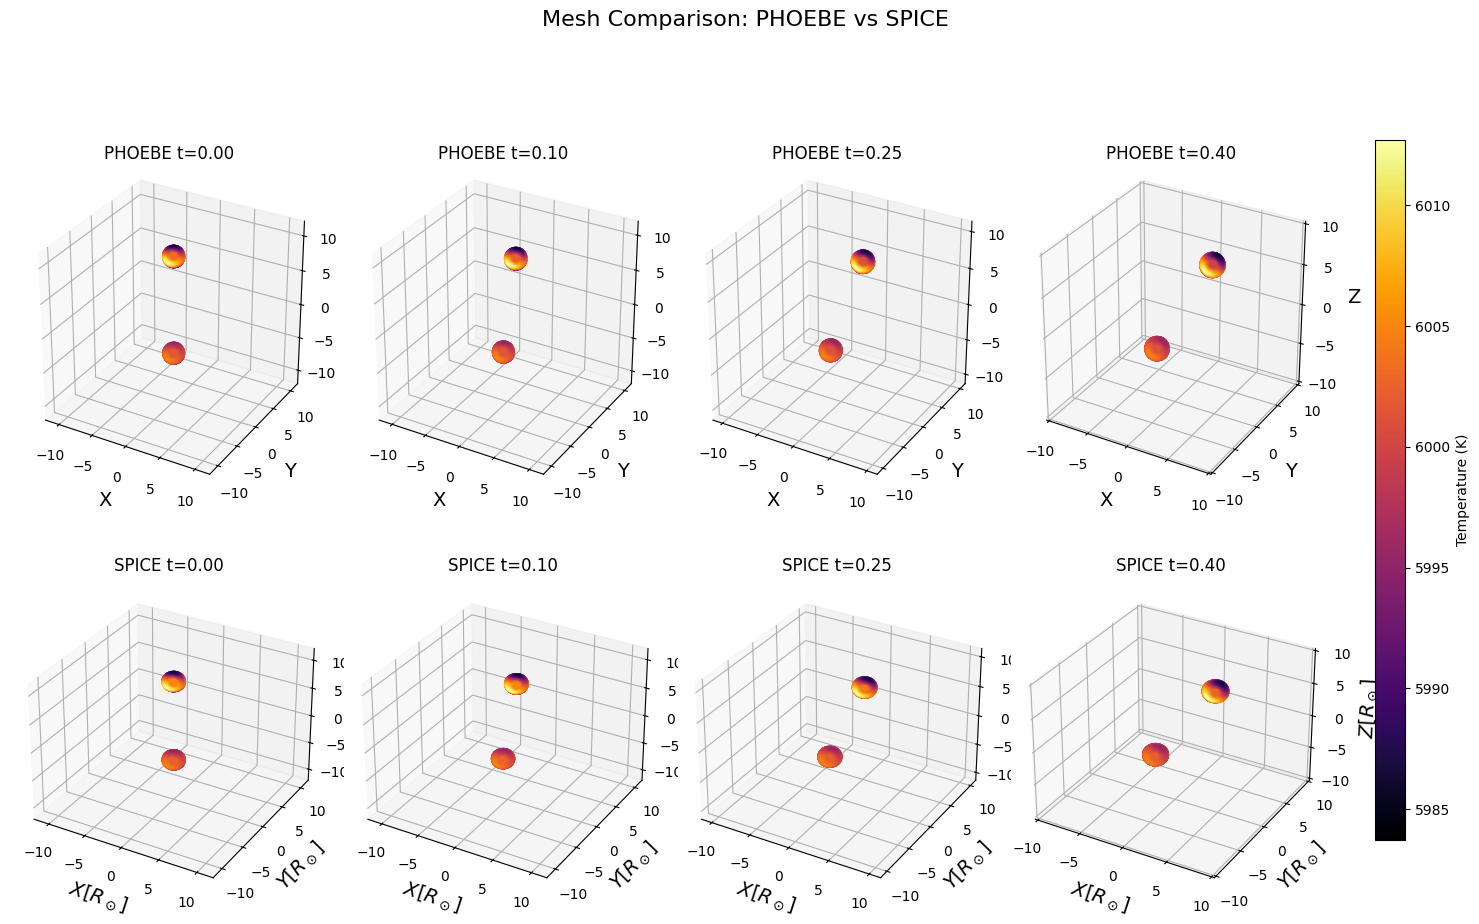

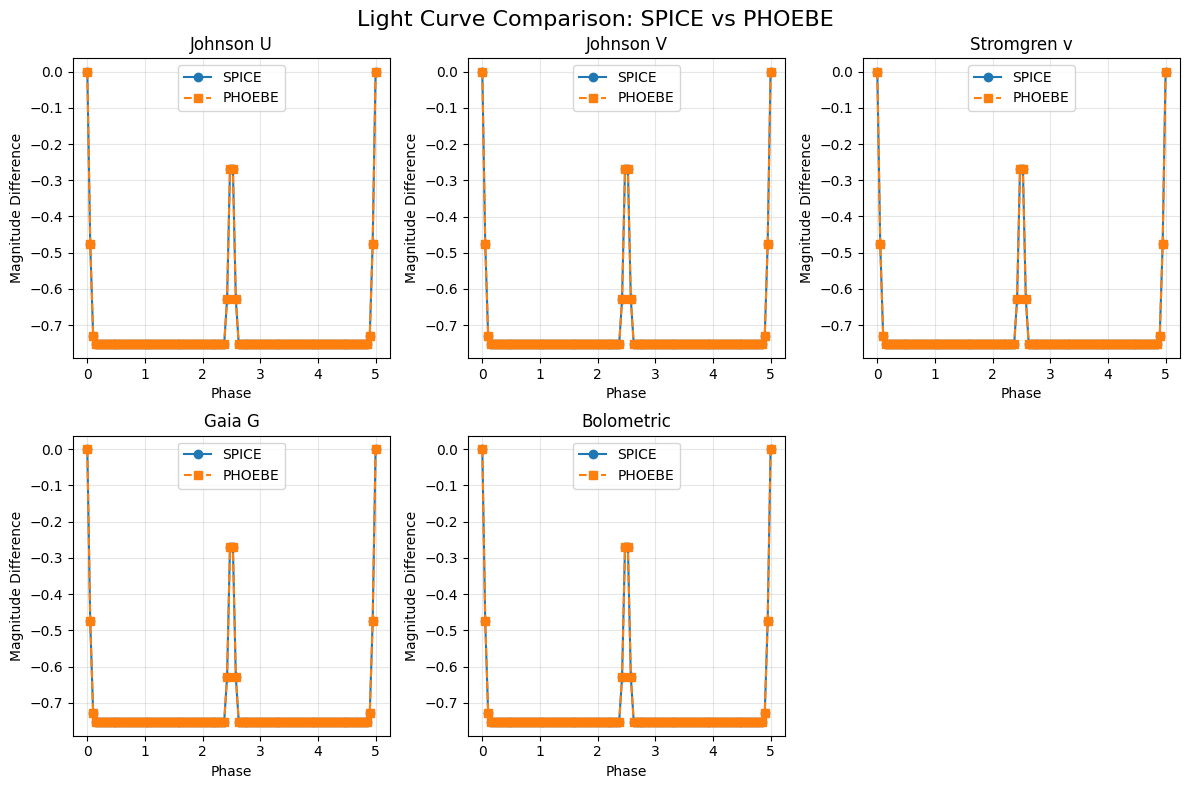

In [64]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
import numpy as np
from tqdm import tqdm
from spice.plots.plot_mesh import plot_3D_binary

# Select a few timesteps to visualize
timesteps = [0, 2, 5, 8]  # Beginning, quarter phase, half phase, three-quarter phase

# Create a figure for the mesh plots
fig = plt.figure(figsize=(15, 10))
fig.suptitle("Mesh Comparison: PHOEBE vs SPICE", fontsize=16)

# Plot PHOEBE meshes
for i, ts in enumerate(timesteps):
    # Get PHOEBE mesh data
    mesh_dataset = b.get_model(component='primary', dataset='mesh01', time=times[ts])
    
    # Extract coordinates and temperatures
    xs = mesh_dataset['xs'].value
    ys = mesh_dataset['ys'].value
    zs = mesh_dataset['zs'].value
    temps = mesh_dataset['teffs'].value
    
    # Create subplot for PHOEBE
    ax = fig.add_subplot(2, len(timesteps), i+1, projection='3d')
    ax.set_title(f"PHOEBE t={times[ts]:.2f}")
    
    # Use plot_3D_binary to plot SPICE meshes
    pb1, pb2 = pbs[ts]
    fig, ax = plot_3D_binary(
        pb1, pb2, 
        property=0,  # Use first parameter (temperature)
        axes=(fig, ax),
        cmap='inferno',
        property_label='Temperature (K)',
        mode='POINTS',
        update_colorbar=False,
        draw_los_vector=False,
        draw_rotation_axes=False
    )
    
    # Set equal aspect ratio and labels
    ax.set_box_aspect([1, 1, 1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

# Plot SPICE meshes using plot_mesh.py
for i, ts in enumerate(timesteps):
    # Get SPICE mesh data for both stars
    pb1, pb2 = pbs[ts]
    
    # Create subplot for SPICE
    ax = fig.add_subplot(2, len(timesteps), i+len(timesteps)+1, projection='3d')
    
    # Use plot_3D_binary to plot both stars
    fig, ax = plot_3D_binary(
        pb1, pb2, 
        property=0,  # Use first parameter (temperature)
        axes=(fig, ax),
        cmap='inferno',
        property_label='Temperature (K)',
        mode='POINTS',
        update_colorbar=False,
        draw_los_vector=False,
        draw_rotation_axes=False
    )
    
    ax.set_title(f"SPICE t={times[ts]:.2f}")

# Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('Temperature (K)')

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show();

# Also plot the light curves for comparison
plt.figure(figsize=(12, 8))
filter_names = ['Johnson U', 'Johnson V', 'Stromgren v', 'Gaia G', 'Bolometric']

for i, (spice_diff, phoebe_diff, name) in enumerate(zip(diffs_spice, diffs_phoebe, filter_names)):
    plt.subplot(2, 3, i+1)
    plt.plot(times, spice_diff, 'o-', label='SPICE')
    plt.plot(times, phoebe_diff, 's--', label='PHOEBE')
    plt.title(name)
    plt.xlabel('Phase')
    plt.ylabel('Magnitude Difference')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Light Curve Comparison: SPICE vs PHOEBE', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show();


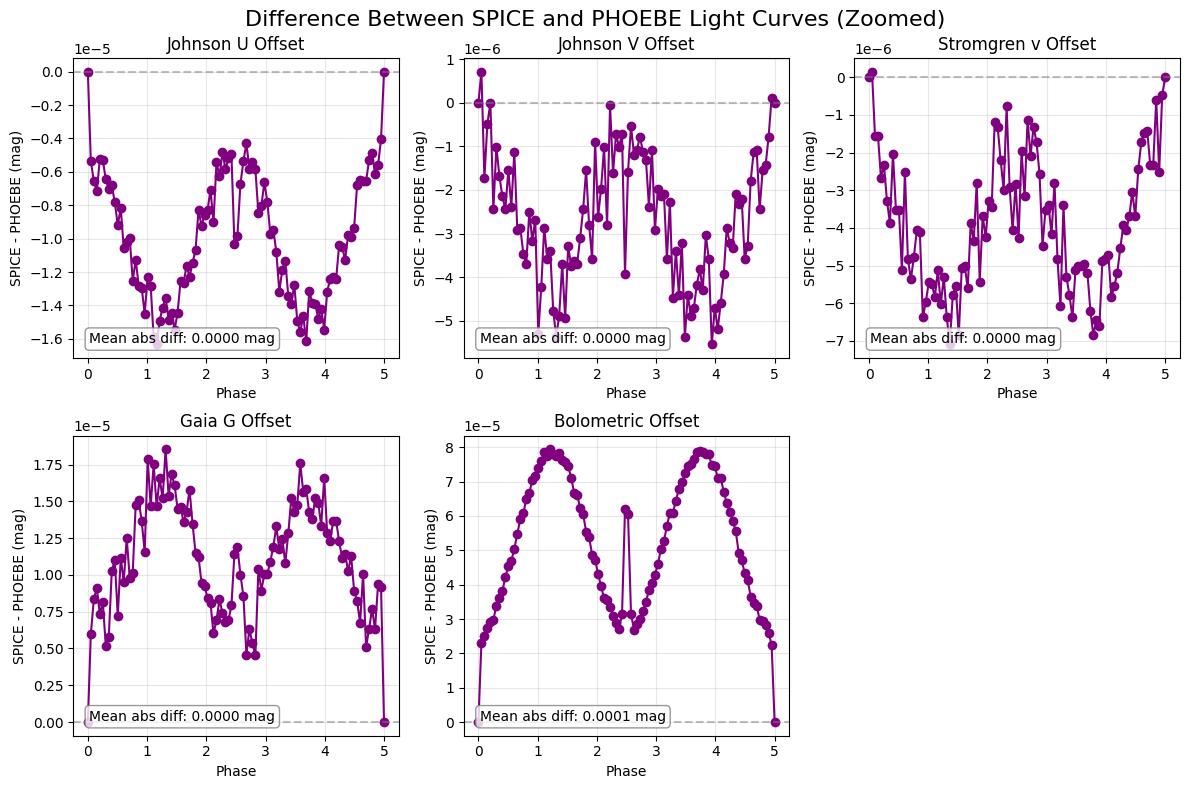

In [65]:
# Plot the offsets between SPICE and PHOEBE light curves (zoomed in)
plt.figure(figsize=(12, 8))

for i, (spice_diff, phoebe_diff, name) in enumerate(zip(diffs_spice, diffs_phoebe, filter_names)):
    plt.subplot(2, 3, i+1)
    
    # Calculate the offset between the two models
    offset = spice_diff - phoebe_diff
    
    # Plot the offset
    plt.plot(times, offset, 'o-', color='purple')
    
    # Add a horizontal line at zero for reference
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    # Set title and labels
    plt.title(f"{name} Offset")
    plt.xlabel('Phase')
    plt.ylabel('SPICE - PHOEBE (mag)')
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)
    
    # Calculate mean absolute difference for the title
    mean_abs_diff = np.mean(np.abs(offset))
    plt.annotate(f'Mean abs diff: {mean_abs_diff:.4f} mag', 
                 xy=(0.05, 0.05), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.suptitle('Difference Between SPICE and PHOEBE Light Curves (Zoomed)', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show();


In [66]:
pbs[50][1].visible_cast_areas

array([-0.00000000e+00,  2.33567345e-05,  5.94889818e-04, ...,
        8.98968001e-08,  8.40533462e-08,  1.84006907e-07])

In [67]:
b.get_parameter('visibilities@primary@latest@model', time=times[50]).value*b.get_parameter('areas@primary@latest@model', time=times[50]).value

array([0.00838488, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ])

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


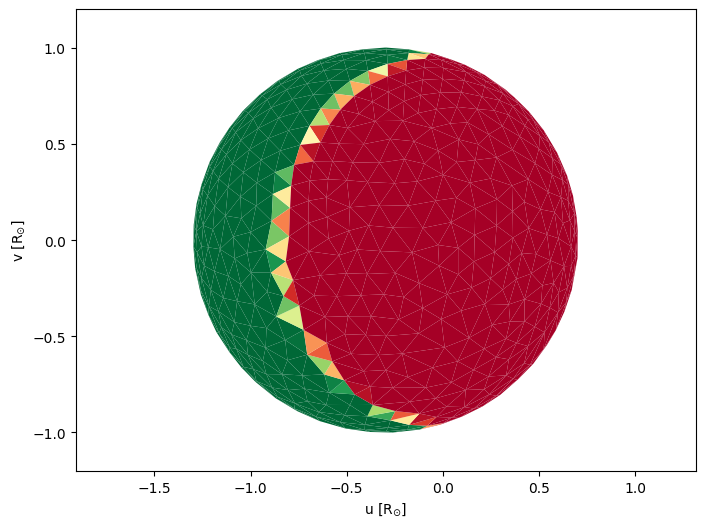

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [68]:
b.plot(kind='mesh', time=times[50], fc='visibilities', ec='none', show=True, component='secondary')

(<Figure size 1000x1200 with 2 Axes>,
 <Axes3D: xlabel='$X [R_\\odot]$', ylabel='$Y [R_\\odot]$', zlabel='$Z [R_\\odot]$'>)

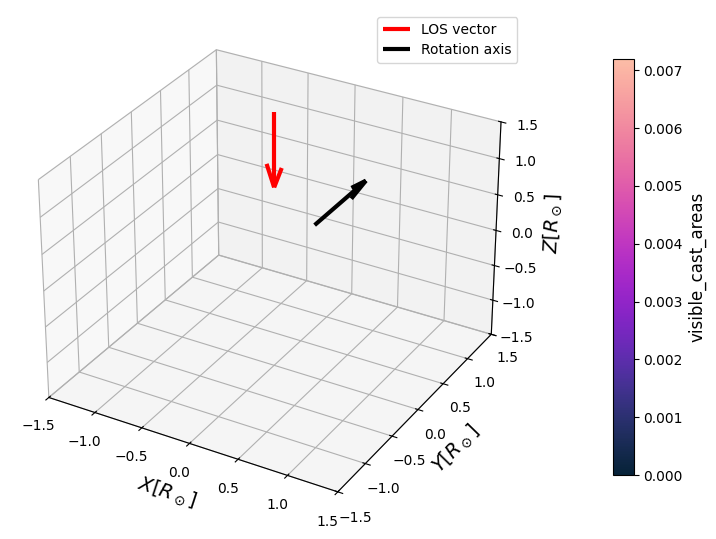

In [69]:
from spice.plots.plot_mesh import plot_3D


plot_3D(pbs[50][1], property='visible_cast_areas')